In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's implement a simple neural network. It will have a quadratic error cost function and ReLu activation functions for the rest

# Defining activation functions and loss functions

In [3]:
def start_layer_weights(n_in, n_out):
    return 0.1*np.random.normal(size=(n_in, n_out))


@np.vectorize
def ReLu(x):
    return x if x > 0 else 0 


@np.vectorize
def dReLu(x):
    return 1 if x> 0 else 0

@np.vectorize
def tanh(x):
    return np.tanh(x)

@np.vectorize
def dtanh(x):
    return 1 - tanh(x)**2

@np.vectorize
def sigmoid(x):
    return 1/(1+np.exp(-x))



@np.vectorize
def dsigmoid(x):
    return np.exp(-x)/(1+np.exp(-x))**2

def loss(Y_true, Y_inf):
    return np.sum((Y_true - Y_inf)**2)


def dloss(Y_true, Y_inf):
    return -2*(Y_true - Y_inf)

# Defining Neural Net / Backpropagation code

In [4]:

    

class FeedForwardNN:


    def __init__(
        self,
        n_in: int, n_out: int,
        hidden_layers: list[int],
        lr: float =0.01):
        """
        Construct basic feedforward neural network

        Parameters
        ----------

            n_in: int
                Number of neurons on the input layer
            n_out: int
                Number of neurons on the output layer
            hidden_layers: list[int]
                list with an integer for each hidden layer with 
                the quantity of neurons.
            lr: float
                Learning rate to configure gradient descent steps
            
        """

        # Storing metadata
        self.n_in = n_in
        self.n_out = n_out
        self.hidden_layers = hidden_layers
        self.lr = lr


        # Hard coding activation function
        # TODO: Make this a parameter
        self.activation_fn = tanh
        self.activation_derivative = dtanh

        # Starting weights and bias
        self.bias = [np.zeros(shape=(size, 1)) for size in hidden_layers + [n_out]]
        self.weights = []

        self.weights.append(start_layer_weights(n_in, hidden_layers[0]))

        for a, b in zip(hidden_layers, hidden_layers[1:]):
            self.weights.append(start_layer_weights(a, b))

        self.weights.append(start_layer_weights(hidden_layers[-1], n_out))

    
        # Starting acummulators
        self.weights_grad = [np.zeros(shape=w.shape) for w in self.weights]
        self.bias_grad = [np.zeros(shape=b.shape) for b in self.bias]
        self.accumulated_grads = 0


    def zerograd(self):
        """Reset the accumulated gradients"""
        self.weights_grad = [np.zeros(shape=w.shape) for w in self.weights]
        self.bias_grad = [np.zeros(shape=b.shape) for b in self.bias]
        self.accumulated_grads = 0


    def predict(self, X_in):
        """
        Do inference using this neural net

        Parameters
        ----------

            X_in: np.array
                column vector of inputs

        Returns
        -------
            Y_out: np.array
                column vector of outputs
        """
        Y = X_in

        for i in range(len(self.weights)):
            Y = self.weights[i].T@Y + self.bias[i]
            if i != len(self.weights) -1:
                Y = self.activation_fn(Y)

        return Y

    
    def forward(self, X_in):
        """
        Same as self.predict, but layer outputs are memorized
        """
        self.outs_a = []
        self.outs_z = []
        self.outs_a.append(X_in)

        Y = X_in

        for i in range(len(self.weights)):
            
            Y = self.weights[i].T@Y + self.bias[i]
            
            self.outs_z.append(Y)
            
            if i != len(self.weights) -1:
                Y = self.activation_fn(Y)
            
            self.outs_a.append(Y)
        
        return Y

    
    def backward(self, Y_true):

        loss_out = loss(Y_true, self.outs_a[-1])
        # print(self.outs_a[-1])
        # print("loss", loss_out)

        # Calculating deltas
        self.delta = [None for i in range(len(self.weights))]

        #  Last layer
        self.delta[-1] = (
            dloss(Y_true, self.outs_a[-1])# * self.activation_derivative(self.outs_z[-1])
        )

        # Middle layers
        for l in range(len(self.weights) - 2, -1, -1):
            
            delta_l = (self.weights[l+1]@self.delta[l+1])*self.activation_derivative(self.outs_z[l])     
            self.delta[l] = delta_l

        # Calculating updates from deltas
        for l in range(len(self.weights)):
            self.weights_grad[l] += self.outs_a[l]@self.delta[l].T   # a[l] because size of a != size weights
            self.bias_grad[l] += self.delta[l]
        
        self.accumulated_grads += 1

        return loss_out


    def step(self):

        for l in range(len(self.weights)):
            self.weights[l] -=  self.lr*self.weights_grad[l]/self.accumulated_grads
            self.bias[l] -= self.lr*self.bias_grad[l]/self.accumulated_grads
            
        self.zerograd()
        
    def __str__(self):
        return f"n_in = {self.n_in}"

In [5]:
nn = FeedForwardNN(1, 1, [2, 3])

nn.forward(np.array([[0.5]]))

len(nn.weights)

nn.backward(np.array([[0.5]]));

for i in nn.delta:
    print(i)
    print()

[[0.00307783]
 [0.0198372 ]]

[[ 0.02701551]
 [-0.13324051]
 [-0.03138858]]

[[-0.99759764]]



# Testing

For testing the code let's create some simulated data to see if we can recover it!

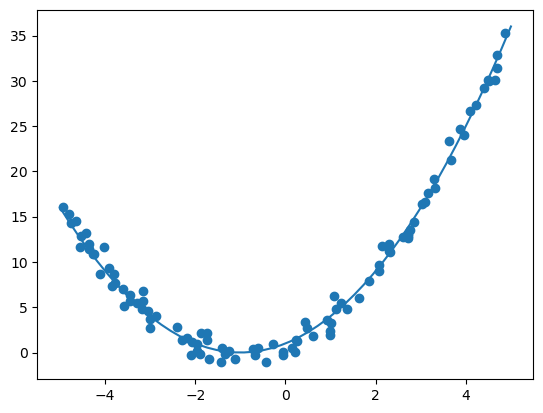

In [48]:

np.random.seed(42)
x = np.random.uniform(-5, 5, size=(100))
y = x**2 + 2*x + 1 + np.random.normal(size=x.shape)

plt.scatter(x, y)

xs = np.linspace(-5, 5)
plt.plot(xs,  xs**2 + 2*xs + 1)

E: 0 - Loss:  136.97823232466715


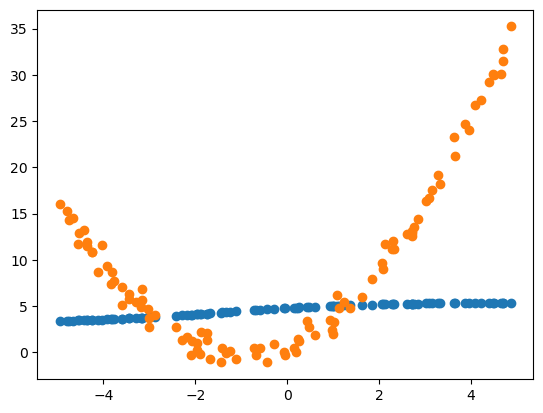

E: 20 - Loss:  29.63418141772753


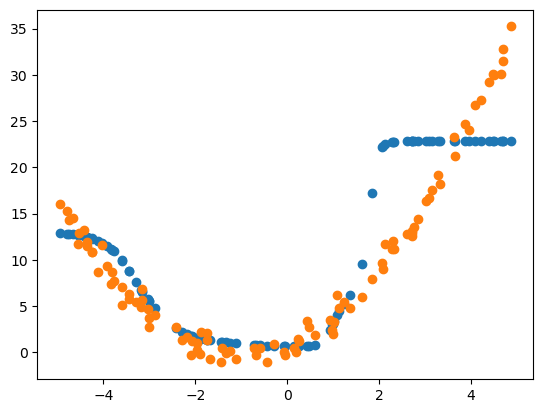

E: 40 - Loss:  9.445234366180287


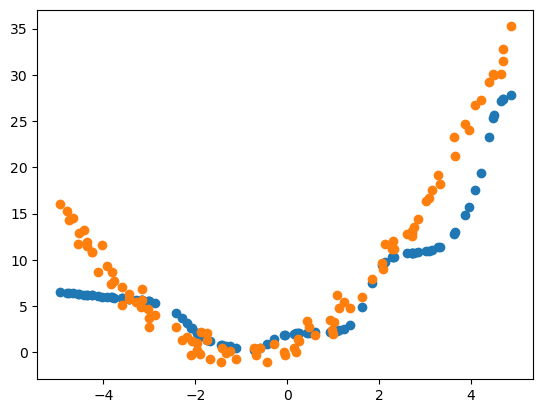

E: 60 - Loss:  2.6574518769969155


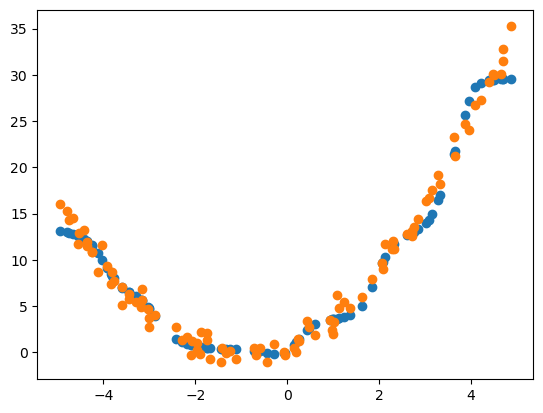

E: 80 - Loss:  3.4209258083760807


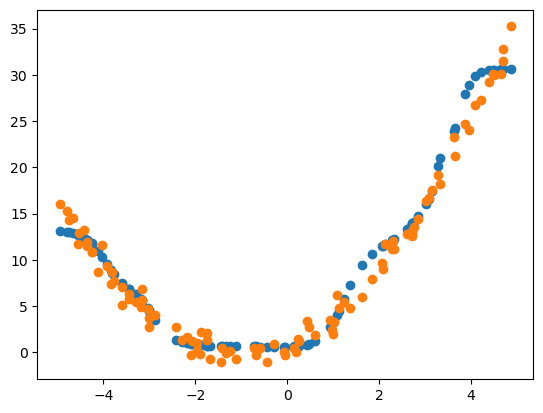

E: 100 - Loss:  2.6248797661901655


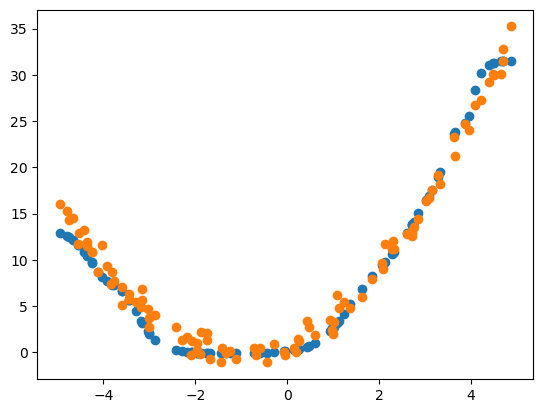

E: 120 - Loss:  3.2937687392316373


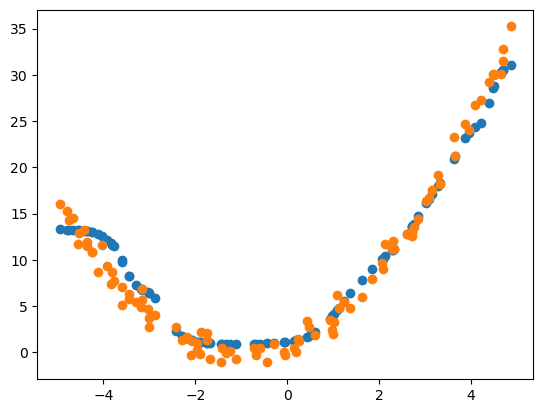

E: 140 - Loss:  1.7535204447913364


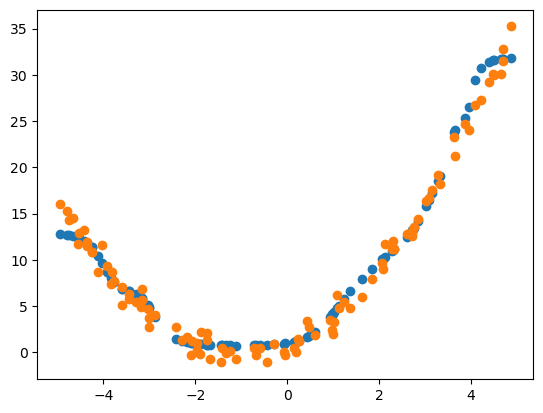

E: 160 - Loss:  2.350867916019935


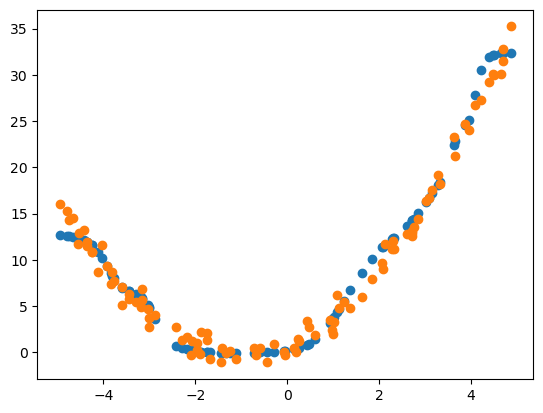

E: 180 - Loss:  2.217873957157475


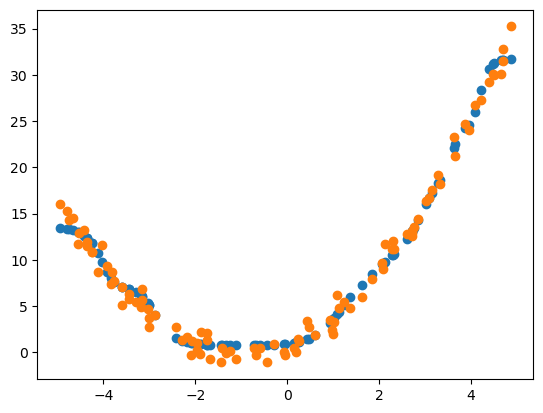

E: 200 - Loss:  2.401885367864726


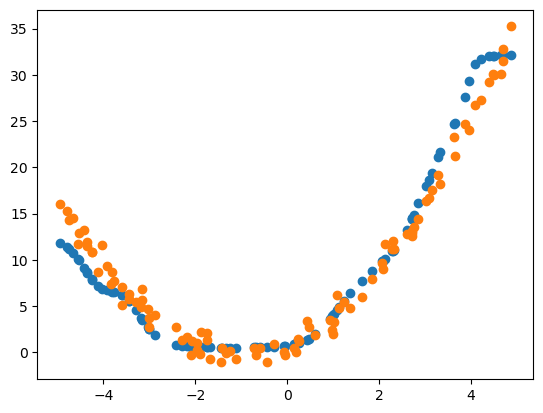

E: 220 - Loss:  3.045524051632195


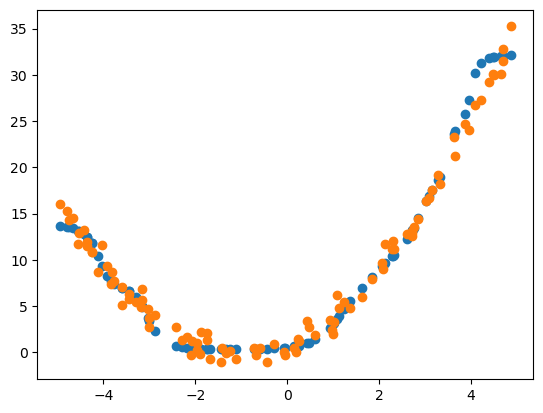

E: 240 - Loss:  1.58461560358922


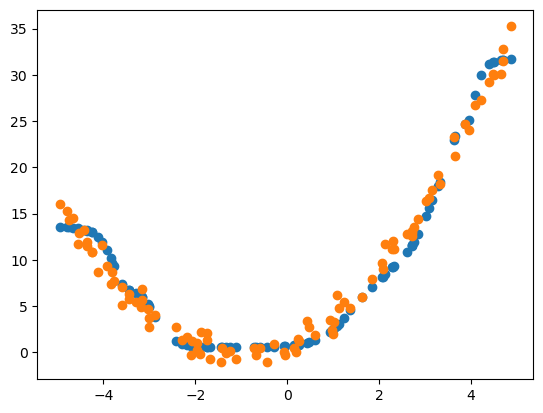

E: 260 - Loss:  1.7244977222621332


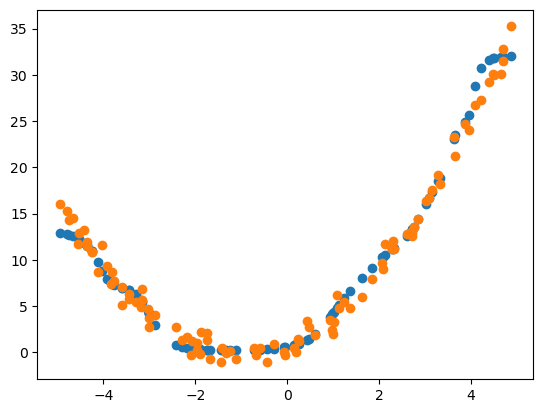

E: 280 - Loss:  2.527653700995754


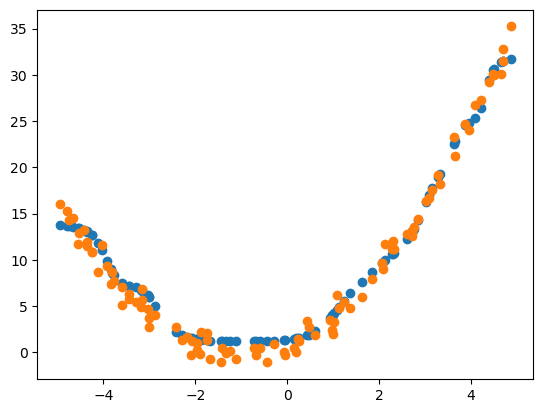

E: 300 - Loss:  1.9367508169940433


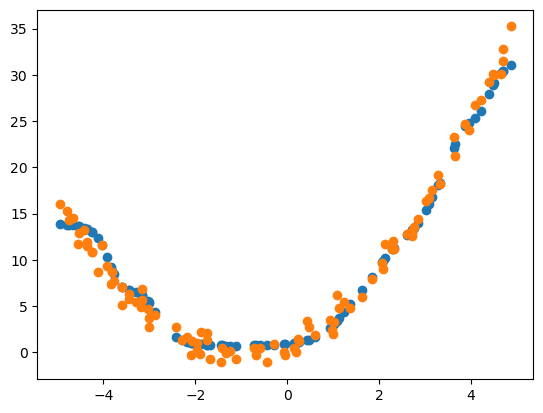

E: 320 - Loss:  1.6533317067305928


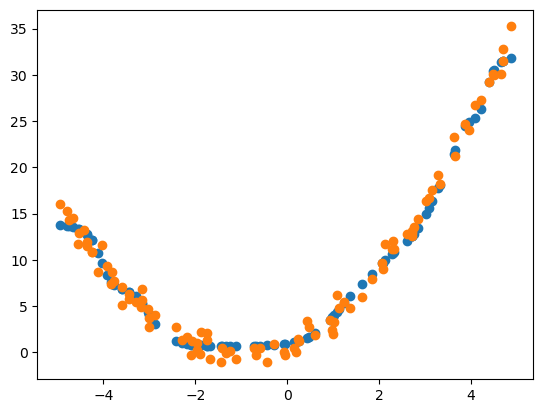

E: 340 - Loss:  1.619668980134043


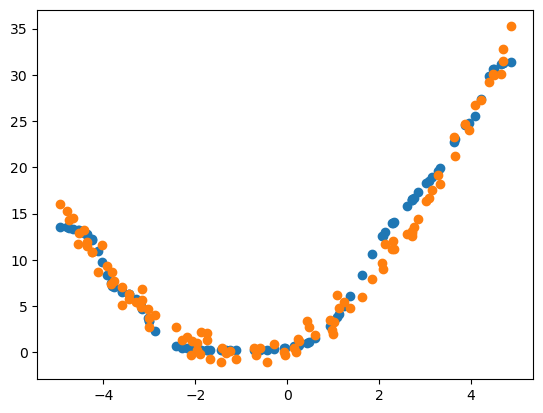

E: 360 - Loss:  1.7863892070102303


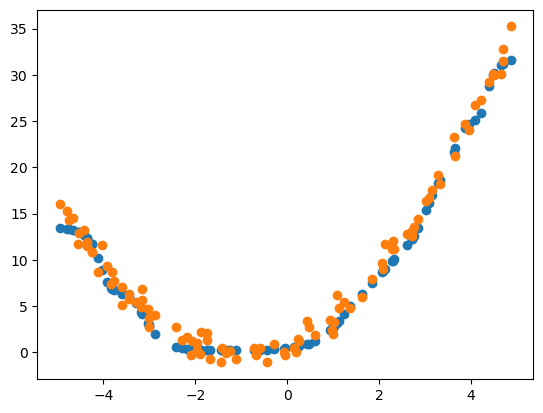

E: 380 - Loss:  1.9700257584644365


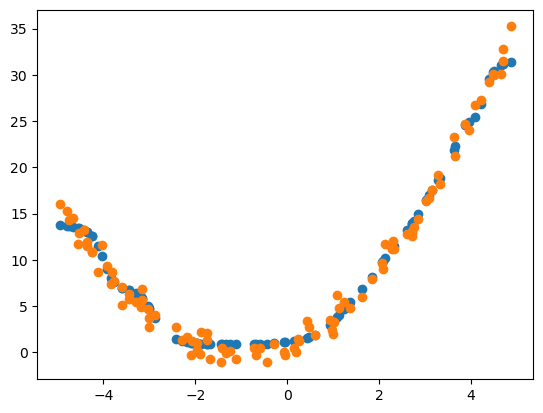

E: 400 - Loss:  2.3209534894799875


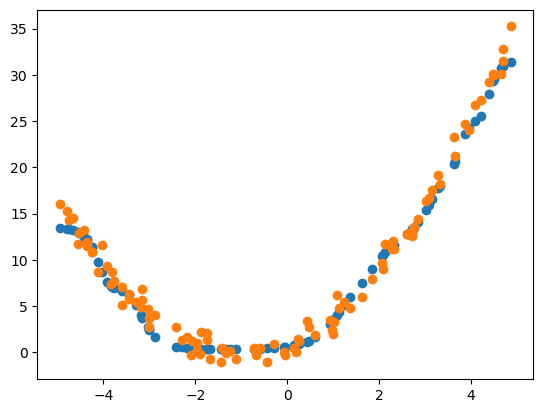

E: 420 - Loss:  2.01771541404066


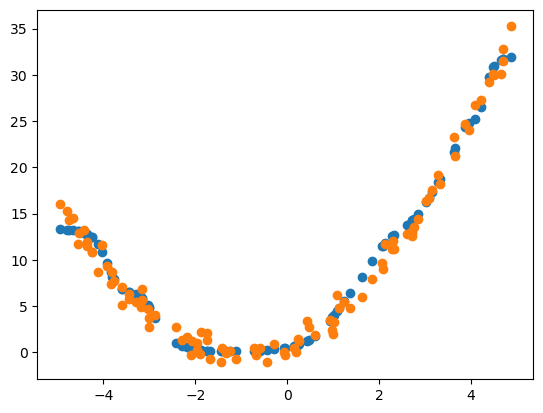

E: 440 - Loss:  1.9323344337119153


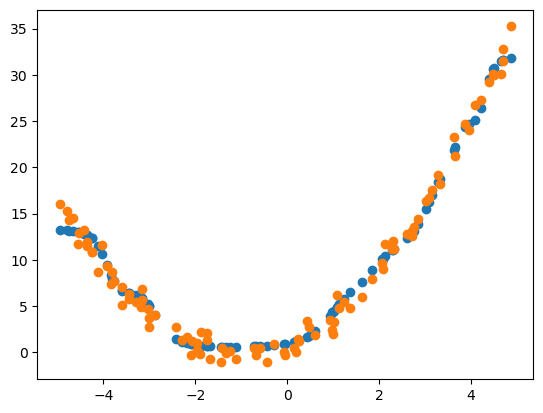

E: 460 - Loss:  1.5786944147502795


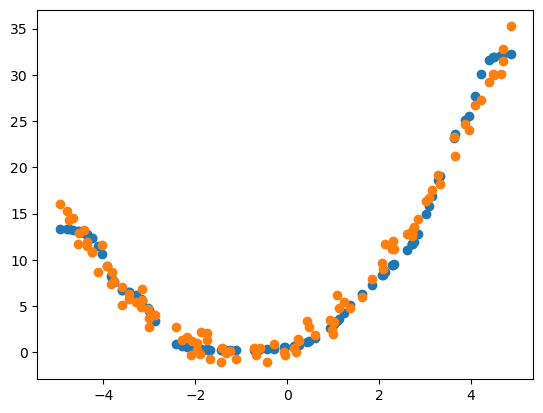

E: 480 - Loss:  1.6130752061411315


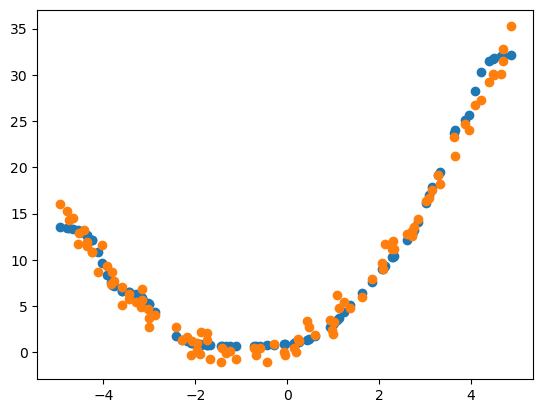

E: 500 - Loss:  1.6991463894478827


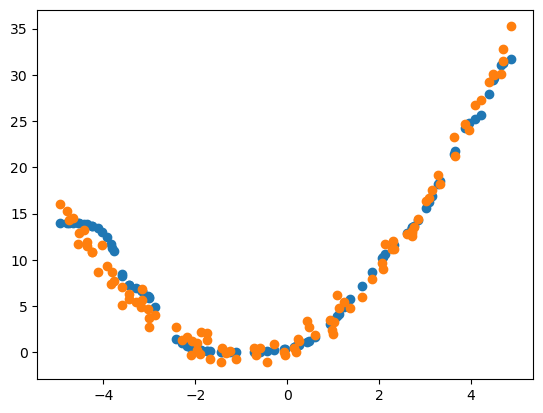

E: 520 - Loss:  1.9317775064631642


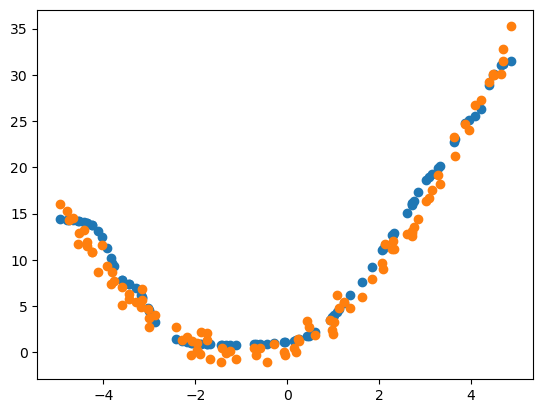

E: 540 - Loss:  1.6124351564731216


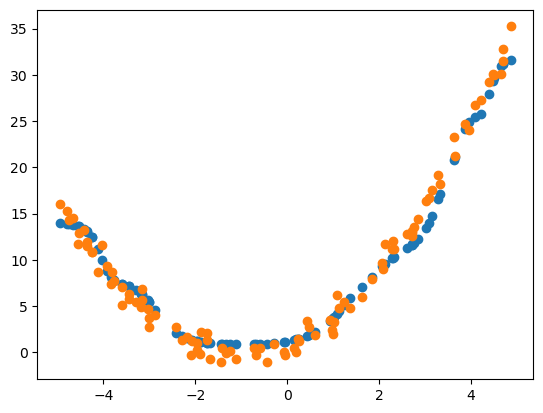

KeyboardInterrupt: 

In [65]:
np.random.seed(42)

nn = FeedForwardNN(1, 1, [5, 5], lr=0.01)

bsize = 20
parts = len(y)/bsize


for i in range(1000):
    
    
    p = np.random.permutation(len(x))

    xp, yp = x[p], y[p]
    
    batch_x, batch_y = np.split(xp, bsize), np.split(yp, bsize)

    losses = []
    for j, bx, by in zip(range(len(batch_x)), batch_x, batch_y):
        
        
        for xt, yt in zip(bx, by):
            nn.forward(np.array([[xt]]))
            l = nn.backward(np.array([[yt]]))
            losses.append(l)
            
        nn.step()

    if i % 20 == 0:
        print(f"E: {i} - Loss: ", sum(losses)/len(losses))
        yr = []
        
        for xt in x:
            yr.append(nn.predict(np.array([[xt]])).item())
        
        plt.scatter(x, yr)
        plt.scatter(x, y)
        plt.show()
                
   


It works !!!!